# Chapter 2.  What's in my sample

Welcome to this introduction to the programmatic access capabilities for Metabolite Atlas. The full Github repository is available at https://github.com/benbowen/metatlas. 

Other resources can be found at the project's homepage: https://metatlas.nersc.gov/

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
from matplotlib import pyplot as plt
import requests, json
import numpy as np
import sys
import os
sys.path.append( '/Users/bpb/Data/programming/MetaboliteAtlas/github/metatlas/' )
import metatlas
# from bokeh.plotting import *
# output_notebook()
import re

# Authenticate

Run the next block once to setup the csrf token for subsequent calls to the server.  Ensure that the password is never checked into the repository.  I think the token lasts for 12 hours.

In [ ]:
# when ipython notbook releases update replace this block with getpass
# NEVER CHECKIN THE USERINFO.TXT FILE TO THE REPO!!!!!
userFile = '../userinfo.txt'
client = metatlas.authenticateUser(userFile)

# get an experiment ID
experiments = metatlas.listMyExperiments(client)
for experiment in experiments:
    print 'NAME = %s;ID = %s' % (experiment[u'name'], experiment[u'_id'])


# Get an experiment ID

In the previous block, if you logged in successfully a list of all experiments from the server will appear.  Filter that list of experiments to match your experiment name.  This gets the experiment UUID from the one you want from the list of experiment names.  We'll need the myExperimentID to find a file that we want to operate on.

In [ ]:
#### edit the myExperimentID string ####
myExperimentID = '542f304ff207836cd3c82bc1'
print myExperimentID

## share an experiment with another user

In [ ]:
# Share the experiment and dictionary with another user.
payload = {"user":'username',"perms":["read","write"]}
sendData=json.dumps(payload)
url = 'https://metatlas.nersc.gov/api/experiment/%s/share/' % myExperimentID
r = client.post(url, data=sendData)
print r.content
url = 'https://metatlas.nersc.gov/api/dict/%s/share/' % dictId
r = client.post(url, data=sendData)
print r.content

<h1>User Specified Grouping Information and Sample Information</h1>
<br>
<h3>A tab-delimited text files is created listing all the runs in an experiment.  It is the users responsibility to specify, plot order, polarity, and sapling grouping.  Save the file as a tab-delimited text file, and we'll use it in future code blocks.</h3>
<br>
Taking "myExperimentID" from the cell above, we can use that here to get all the files for that experiment.  This is stored in "files".  Print "files" and see all the runs.  I use a filter with a preffered file name specified in "myFilename" to get the run I want.  The pending status is also printed for each run:
The output file lists the following fields:
1. Index
2. Status
    1. pending = 0 means loaded or finished converting
    2. pending = 1 means pending or just uploaded
    3. pending = 2 means loading or in process of converting
3. name
    1. This is the name and location of the file where it was uploaded to
4. fid
    1. This is the index in the SciDB array that identifies all the datapoints in your file
5. polarity
    1. Specify Whether the file was acquired in positive or negative ionization mode
6. group
    1. A grouping descriptor to be used for analysis.  Things like "control" and "treatment" for each file will allow those files to be grouped and processed by later code blocks
7. inclusion_order
    1. Put numerical values here to configure your plots to be in the order you want
8. normalization_factor
    1. A factor to divide the intensity of observed molecules by.  This can partially correct for artifacts introduced by loading and extraction inconsistencies.  Use with care and avoid by careful experimental design.
9. retention_correction
    1. A number (in minutes) to shift the retention time by

In addition, the path to the experiment is stored.<br>


In [ ]:
url = 'https://metatlas.nersc.gov/api/experiment/%s' % myExperimentID
r = client.get(url)
files = json.loads(r.content)
fileInfo = {'fid':[],'name':[],'status':[]};
fid = open('fileInfo.tab','wb')
fid.write('index\tstatus\tname\tfid\tpolarity\tgroup\tinclusion_order\tnormalization_factor\tretention_correction\n')
for i,myRun in enumerate(files[u'runs']):
    splitPathToFile = os.path.split(myRun[u'in_file'])
    fid.write('%d\t%d\t%s\t%d\tpos\tgroup1\n' % (i,myRun[u'pending'],splitPathToFile[1],myRun[u'_id'][u'file_id']))
    if myRun[u'pending'] == 0:
        fileInfo['fid'].append(myRun[u'_id'][u'file_id'])
        fileInfo['name'].append(splitPathToFile[1])
        fileInfo['status'].append(myRun[u'pending']) #only keep if status is 0
pathYouWant = splitPathToFile[0] # TODO: we will have to see what this will do on a window's computer.  taking a linux path and using os.
fid.close()

In [ ]:
# import the fileInfo sheet with annotated group information, polarity, and plot order
url = 'https://metatlas.nersc.gov/api/experiment/%s' % myExperimentID
r = client.get(url)
files = json.loads(r.content)
myArray = files[u'runs'][0][u'_id'][u'array_name']

filename = 'fileInfo_pos_demo_experiment.txt'
with open(filename,'rU') as file_object:
    newfileInfo = list(csv.DictReader(file_object, dialect='excel-tab'))
keys = newfileInfo[0].iterkeys()
fileInfo = {key: [d[key] for d in newfileInfo] for key in keys}
fileInfo['fid'] = map(int, fileInfo['fid'])
fileInfo['index'] = map(int, fileInfo['index'])
fileInfo['inclusion_order'] = map(int, fileInfo['inclusion_order'])
fileInfo['status'] = map(int, fileInfo['status'])
fileInfo['normalization_factor'] = map(float, fileInfo['normalization_factor'])
# fileInfo['retention_correction'] = map(float, fileInfo['retention_correction'])

idx = np.argsort(fileInfo['inclusion_order'])
export_fileIds = np.asarray(fileInfo['fid'])[idx]


Take the file you want and paste it below.  All the files should be on the same path; so the last path listed is fine.

The block below will give you the SciDB array name and the RunID.  We'll need these variables in the block below.

In [ ]:
#### edit the fileYouWant string ####
# fileYouWant = '140905_0_4_RT_pos.mzML'
# myFilename = '%s/%s' % (pathYouWant, fileYouWant)
# myMatch = filter( lambda x: x[u'in_file']==myFilename and x[u'pending']==0, files[u'runs'] )[0][u'_id']
# myArray = myMatch[u'array_name']
# myRunID = myMatch[u'file_id']
# print myRunID

### Defining the File Ids that we want to consider for our analysis. 

### Get the EICs for all files in the list "export_fileIds" for all compounds in your Atlas

In [ ]:
import time
polarity = 1
extraTime = 0.3
data = []
dataIsotope = []
i = 0
myList = ','.join(map(str, export_fileIds))
print myList
for compound in dictData[u'compounds']:
    try:
        print i, " target worked"
        data.append(metatlas.getEICForCompounds(compound,myArray,export_fileIds,extraTime,client,polarity))
        time.sleep(0.51) 
    except:
        print i, " target data failed (probably because server is overloaded)"
        data.append([])

    try:
        print i, " isotope worked"
        dataIsotope.append(metatlas.getEICForCompounds_oneLighter(compound,myArray,export_fileIds,extraTime,client,polarity))
        time.sleep(0.51) 
    except:
        print i, " failed"
        data.append([])
        
    i = i+1

In [ ]:
metatlas_data = {'dictId':dictId,'myExperimentID':myExperimentID,'dictData':dictData, 'data':data,'dataIsotope':dataIsotope,'fileInfo':fileInfo,'myList':myList,'export_fileIds':export_fileIds}
import pickle
pickle.dump( metatlas_data, open( "export_atlas_data_experiment.pkl", "wb" ) )

In [ ]:
# for each compound, make a chromatogram for each file
# each filename is going to be a compound name
export_filenames = []
for i,compound in enumerate(dictData[u'compounds']):
    export_filenames.append('%s%s' % (re.sub('[^A-Za-z0-9]+', '_', compound[u'name']),'_lipids_pos.pdf'))

subplot_titles = []
for i,myFile in enumerate(export_fileIds):
    for j,fid in enumerate(fileInfo['fid']):
        if fid == myFile:
            subplot_titles.append(fileInfo['name'][j].replace('.mzML',''))

# %config InlineBackend.figure_format = 'png' 
numCols = 4.
nRows = int(np.ceil(len(export_fileIds)/numCols))

for i,compound in enumerate(dictData[u'compounds']):
    fig, ax = plt.subplots(nRows, int(numCols),figsize=(5*numCols,nRows * 5))
#     fig.subplots_adjust(bottom=0.0, left=0.0)
    min_x_val = 1000000
    max_x_val = 0
    for j,a in enumerate(ax.flat):
        if j<len(export_fileIds):
            a.set_title(subplot_titles[j])
            try:
                x1 = data[i][:,0][(data[i][:,2]==export_fileIds[j])]
                y1 = data[i][:,1][(data[i][:,2]==export_fileIds[j])]
                if myname.startswith('ist'):
                    y1 = y1[:]
                else:
                    y1 = y1[:] / fileInfo['normalization_factor'][j]
                idx = np.argsort(x1)
                x1 = x1[idx]
                y1 = y1[idx]
                if len(x1)>10:
                    m = np.max(y1)
                    y1 = y1 / m
                    tempData = {'xdata':x1,'ydata':y1,'name':subplot_titles,'iMax':m}
#                     fitResult = metatlas.fitACompound(compound,tempData)
                    metatlas.createChromatogramPlots_dataOnly(tempData,compound,a)
                    a.set_title(subplot_titles[j])
                    if myname.startswith('ist'):
                        a.set_ylim([0,np.max(data[i][:,1])])
                    else:
                        a.set_ylim([0,np.max(data[i][:,1])/0.5])
#                     a.set_ylim([0,np.max(data[i][:,1])])
                    if np.min(data[i][:,0])<min_x_val:
                        min_x_val = np.min(data[i][:,0])
                    if np.max(data[i][:,0])>max_x_val:
                        max_x_val = np.max(data[i][:,0])
                x1 = dataIsotope[i][:,0][(dataIsotope[i][:,2]==export_fileIds[j])]
                y1 = dataIsotope[i][:,1][(dataIsotope[i][:,2]==export_fileIds[j])]
                myname = dictData[u'compounds'][i]['name']
                
                idx = np.argsort(x1)
                x1 = x1[idx]
                y1 = y1[idx]
                
                if len(x1)>10:
                    a.plot(x1,y1,'b-',linewidth=2.0,alpha=0.5)

            except:
                m = 1+1
    for j,a in enumerate(ax.flat):
        a.set_xlim([min_x_val,max_x_val])
    fig.tight_layout()        
#     fig.savefig(export_filenames[i])
    
#     fig.clear()
# plt.rcParams['ps.fonttype']=42
# plt.rcParams['ps.useafm']= True


In [ ]:
# for each files, makes chromatogram and fits for each compound
# each file gets saved as a separate graphic
export_filenames = []
for i,myFile in enumerate(export_fileIds):
    for j,fid in enumerate(fileInfo['fid']):
        if fid == myFile:
            export_filenames.append(fileInfo['name'][j].replace('mzML','updated_rt.pdf'))
# %config InlineBackend.figure_format = 'png' 

numCols = 1.

nRows = int(np.ceil(len(dictData[u'compounds'][:])/numCols))

    
for j,myFile in enumerate(export_fileIds):
    # j=1
    # myFile = export_fileIds[1]
    fig, ax = plt.subplots(nRows, int(numCols),figsize=(25*numCols,nRows * 5))
#     fig.subplots_adjust(bottom=0.0, left=0.0)
    for i,a in enumerate(ax.flat):
        if i<len(dictData[u'compounds']):
            a.set_title(dictData[u'compounds'][i][u'name'])
            try:
                x1 = data[i][:,0][(data[i][:,2]==myFile)]
                y1 = data[i][:,1][(data[i][:,2]==myFile)]
                idx = np.argsort(x1)
                x1 = x1[idx]
                y1 = y1[idx]
                if len(x1)>10:
                    m = np.max(y1)
                    y1 = y1 / m
                    tempData = {'xdata':x1,'ydata':y1,'name':dictData[u'compounds'][i]['name'],'iMax':m}
#                     fitResult = metatlas.fitACompound(dictData[u'compounds'][i],tempData)
#                     metatlas.createChromatogramPlots(tempData,dictData[u'compounds'][i],fitResult,a)
                    metatlas.createChromatogramPlots_dataOnly(tempData,dictData[u'compounds'][i],a)

            except:
                m = 1+1
            x1 = dataIsotope[i][:,0][(dataIsotope[i][:,2]==myFile)]
            y1 = dataIsotope[i][:,1][(dataIsotope[i][:,2]==myFile)]
            idx = np.argsort(x1)
            x1 = x1[idx]
            y1 = y1[idx]
            if len(x1)>10:
                a.plot(x1,y1,'b-',linewidth=2.0,alpha=0.5)
            minX, maxX = a.get_xlim()
            a.xaxis.set_ticks(np.arange(minX, maxX, 0.1))
#     fig.tight_layout()
#     fig.savefig(export_filenames[j])
#     fig.clear()

# 5. Get an EIC or TIC

In the next blocks, we'll make a TIC.  If you use the standard internal standards, the m/z values below will be useful for debugging problematic runs.

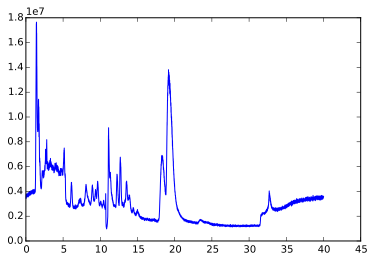

In [43]:
payload = {'L':1,'P':1,'arrayname':myArray,'fileid':export_fileIds[0],
           'max_mz':800,'min_mz':123,
           'nsteps':20000,'queryType':'XICofFile'}
url = 'https://metatlas.nersc.gov/api/run'

r = client.get(url,params=payload)
data = np.asarray(json.loads(r.content))
plt.plot(data[:,0],data[:,1])
# plt.xlim(0,)

In [ ]:
# metatlas = reload(metatlas)
# for myFile in export_fileIds:
#     x1 = data[:,0][(data[:,2]==myFile)]
#     y1 = data[:,1][(data[:,2]==myFile)]
#     idx = np.argsort(x1)
#     y1_min = []
#     for x in metatlas.sliding_window_minimum(1, y1[idx]):
#         y1_min.append(x)
# #     y1_min = metatlas.sliding_window_minimum(5,)
# #     print y1_min
# #     plt.plot(x1[idx],y1[idx])
#     plt.plot(x1[idx],y1_min)
# plt.xlabel('Time (min)')
# plt.ylabel('TIC Intensity (au)')


In [ ]:
#get multiple files
# files_I_want = spentFiles_pos+mediaFiles_pos+blankFiles_pos+qc_CAS16_Files_pos+qc_CAS17_Files_pos
files_I_want = export_fileIds
# files_I_want = fileInfo ['pos_groups'][u'2@23'][:]
# groups = fileInfo ['groups'].keys()
# files_I_want = []
# for group in groups:
#     files_I_want = files_I_want + fileInfo['groups'][group]
# files_I_want = qc_CAS17_Files_pos+qc_CAS16_Files_pos
myList = ','.join(map(str, files_I_want))
payload = {'L':1,'P':1,'arrayname':myArray,'fileidlist':myList,
          'max_mz':995.99,'min_mz':995.95,
          'min_rt':14.1,'max_rt':14.5,
          'nsteps':20000,'queryType':'XICofFile_mf'}
url = 'https://metatlas.nersc.gov/api/run'
r = client.get(url,params=payload)
data = np.asarray(json.loads(r.content))
print data.shape
# sliding_window_minimum(k, li):
I = []
for myFile in files_I_want:
    x1 = data[:,0][(data[:,2]==myFile)]
    y1 = data[:,1][(data[:,2]==myFile)]
    I.append(np.sum(y1))
    idx = np.argsort(x1)
    plt.plot(x1[idx],y1[idx])

plt.xlabel('Time (min)')
plt.ylabel('TIC Intensity (au)')
# plt.xlim(5,15)
print np.mean(I)
print np.min(I)
print np.max(I)


# Select a Metabolite Atlas From the System

In [ ]:
# Get a list of all method specific metabolite atlases in the system
# GET /api/dict/
url = 'https://metatlas.nersc.gov/api/dict/'
r = client.get(url)
allAtlases = json.loads(r.text)
for atlas in allAtlases:
    atlas_str = '%s has an atlas named %s has the ID: %s' % (atlas[u'creator'],atlas['name'], atlas['_id'])
    print atlas_str

In [ ]:
# Get the entries for a specific dictionary
# GET /api/dict/<dict_id>/
dictId = '54109ee67626405078e50035'
url = 'https://metatlas.nersc.gov/api/dict/%s/' % dictId
r = client.get(url)
dictData = json.loads(r.text)
print dictData

In [ ]:
# Adds the specified compound dictionary to the experiment
# POST	/api/experiment/<experiment_id>/dict/	{ "dict_id": <dict_id_to_be_added> } JSON
url = 'https://metatlas.nersc.gov/api/experiment/%s/dict/' % myExperimentID
payload = {"dict_id":dictId}
r = client.post(url, data=json.dumps(payload))
print(r.text)

In [ ]:
#add compounds to an atlas from a well formated spreadsheet
import csv
# filename = 'example_metatlas_spreadsheet.txt'
# filename = 'atlas_export_rch2_neg.txt'
filename = 'atlas_export_lipids_pos.txt'

with open(filename,'rU') as file_object:
    payload = list(csv.DictReader(file_object, dialect='excel-tab'))

url = 'https://metatlas.nersc.gov/api/dict/%s/' % dictId
r = client.post(url, data=json.dumps(payload))

url = 'https://metatlas.nersc.gov/api/dict/%s/' % dictId
r = client.get(url)
dictData = json.loads(r.text)
print dictData

In [ ]:
#add compounds to an atlas from a well formated spreadsheet that are new and
#update any that were already there, but have changed
import csv
# filename = 'example_metatlas_spreadsheet.txt'
filename = '/Users/bpb/Data/programming/MetaboliteAtlas/Atlases/TAG_internal_standards.txt'
with open(filename,'rU') as file_object:
    sheetData = list(csv.DictReader(file_object, dialect='excel-tab'))

url = 'https://metatlas.nersc.gov/api/dict/%s/' % dictId
r = client.get(url)
dictData = json.loads(r.text)

for compound in sheetData:
    print compound
    cID = filter( lambda x: x[u'name']==compound['name'], dictData[u'compounds'])
    print cID
    if not cID:
        # a new entry is created if that compound name doesn't exist
        url = 'https://metatlas.nersc.gov/api/dict/%s/' % dictId
        r = client.post(url, data=json.dumps([compound]))
        print(r.text)
    else:
        # edit the entry if it already exists
        url = 'https://metatlas.nersc.gov/api/compound/%s/' % cID[0][u'_id']
        r = client.patch(url, data=json.dumps(compound))
        print(r.text)
url = 'https://metatlas.nersc.gov/api/dict/%s/' % dictId
r = client.get(url)
dictData = json.loads(r.text)        


In [ ]:
# export an atlas
myList = ['name','pubchem_id','formula','neutral_mass','mz','mz_threshold','adducts','rt_max','rt_min','rt_peak']
import csv
filename = 'atlas_export_sar11.txt'
fid = open(filename,'wb')
for listItem in myList:
    fid.write('%s\t' % listItem)
fid.write('\n')
for i,compound in enumerate(dictData[u'compounds']):
    for listItem in myList:
        fid.write('%s\t' % compound[listItem])
    fid.write('\n')
fid.close()

# Share an Atlas with another person

In [ ]:
# POST /api/dict/<dict_id>/share/
# { "user": "<username", [or "group": "<groupname>"], "perms": [... list of perms (i.e. "read", "write", "admin")] } 
# JSON
# Gives the specified user permissions to the compound dictionary        
#     allUsers = ['username']
# allPerms = ["read","write"]
payload = {"user":'username',"perms":["read"]}
sendData=json.dumps(payload)
url = 'https://metatlas.nersc.gov/api/dict/%s/share/' % dictId
r = client.post(url, data=sendData)

# Optimization block to estimate rtPeak and rt bounds

The following block takes a good guess from a user and users non-linear least-squares optimization to provide a best-fit of rt_Peak, rt_min, and rt_max.  In addition it integrates a deconvoluted peak areea.  Make sure you run the block above to get "data", "rtPeak", "rtMin", "rtMax".  The vector "c" produced by this block, produces the best fit values for peak area, rtPeak, rtMin, and rtMax respectively.
<br>
Define the fitting function and the error function to be used in the optimization
<br>
$Intensity(t) = PeakArea * \frac{1}{2}e^{-(t-rtPeak)^2/(rtWidth^2)}$
<br>
In our case, we don't assume that the chromatogram is symetrical in time.  Therefore, we solve the problem from rtPeak forward in time using one width variable, "p[1]".  The solution is also solved less than rtPeak using another width variable, "p[2]".
<br>
For the error function, lets give the error a weight based on the normal probability distribution.  
$E(t) = OriginalData(t) - Intensity(t) * \frac{1}{2}e^{-(t-originalRTPeak)^2/(0.1^2)}$

Modeled peak area is 5770643 from an asymmetric gaussian.
Old rt_peak was at 6.1 minutes and the modeled peak is at 6.128 minutes.
Old rt_min was at 5.7 minutes and the modeled rt_min is at 5.977 minutes.
Old rt_max was at 6.60001 minutes and the modeled rt_max is at 6.294 minutes.


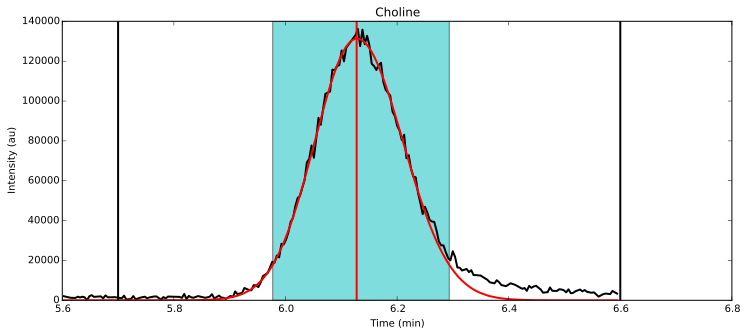

In [44]:
metatlas = reload(metatlas)
polarity = 1 # set to 0 for negative mode and 1 for positive mode
compound = dictData[u'compounds'][4]
data = metatlas.getEICForCompound(compound,myArray,export_fileIds[0],0.5,client,polarity)
fitResult = metatlas.fitACompound(compound,data)

fig, ax = plt.subplots(1, 1,figsize=(12,5))
metatlas.createChromatogramPlots(data,compound,fitResult,ax)

print 'Modeled peak area is %d from an asymmetric gaussian.' % (np.sum(data['iMax']*metatlas.fitfunc(fitResult, data['xdata'])))
print 'Old rt_peak was at %s minutes and the modeled peak is at %5.3f minutes.' % (compound[u'rt_peak'],fitResult[1])
print 'Old rt_min was at %s minutes and the modeled rt_min is at %5.3f minutes.' % (compound[u'rt_min'],fitResult[1]-2*fitResult[3])
print 'Old rt_max was at %s minutes and the modeled rt_max is at %5.3f minutes.' % (compound[u'rt_max'],fitResult[1]+2*fitResult[2])

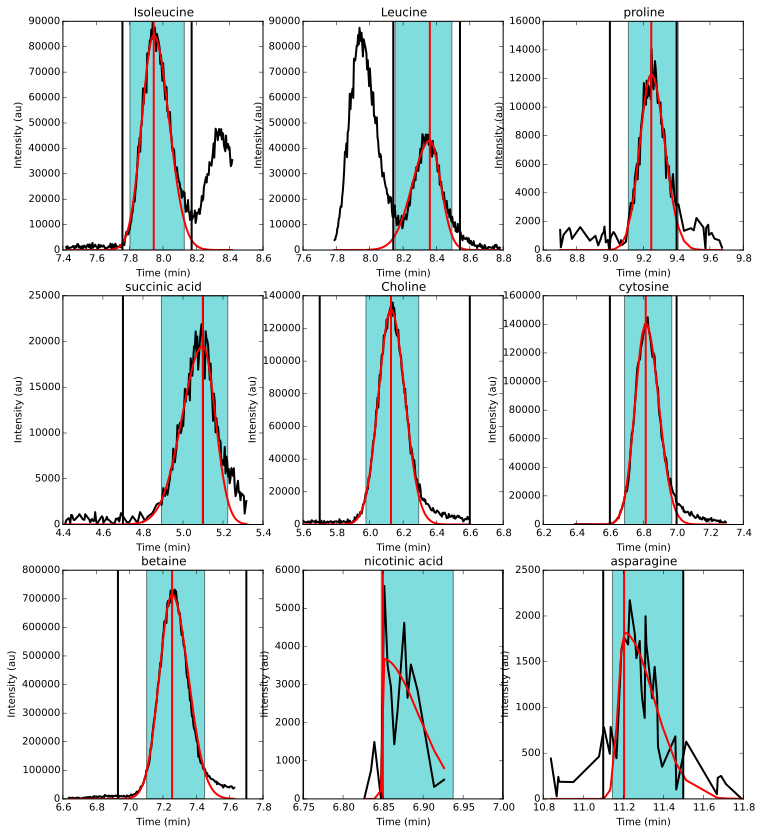

In [45]:
nRows = int(np.ceil(len(dictData[u'compounds'][:8])/3.))
fig, ax = plt.subplots(nRows, 3,figsize=(10.5,nRows * 4))
fig.subplots_adjust(bottom=0.0, left=0.0)
outResults = np.zeros((len(dictData[u'compounds']),4))
polarity = 1
for i,a in enumerate(ax.flat):
    data = metatlas.getEICForCompound(dictData[u'compounds'][i],myArray,export_fileIds[0],0.5,client,polarity)
    if len(data['xdata'])>10:
        fitResult = metatlas.fitACompound(dictData[u'compounds'][i],data)
        metatlas.createChromatogramPlots(data,dictData[u'compounds'][i],fitResult,a)
        outResults[i,:] = fitResult
    else:
        a.set_title(dictData[u'compounds'][i][u'name'])
            

In [ ]:
# fig.savefig('chromatograms.eps')

In [ ]:
fig.savefig('chromatograms.pdf',bbox_inches='tight')

In [ ]:
#Export the values from the curve fits
# name	pubchem_id	formula	neutral_mass	mz	mz_threshold	adducts	rt_max	rt_min	rt_peak
import csv
filename = 'annotations_updated.txt'
fid = open(filename,'wb')
fid.write('%s\t' % 'compound')
fid.write('Area\trtPeak\tsig1\tsig2\n')
for i,compound in enumerate(dictData[u'compounds']):
    fid.write('%s\t' % compound[u'name'])
    for result in outResults[i,:]:
        fid.write('%5.5f\t' % result)
    fid.write('\n')
fid.close()


In [ ]:
# Create a new entry for a dictionary
# POST /api/dict/<dict_id>/
# payload = [{"adducts":"H+","formula":"C6H13NO2","name":"Isoleucine","rt_max":8.6,"rt_min":3,"rt_peak":7.5,"mz":132.101876,"mz_threshold":5,"neutral_mass":131.0946,"pubchem_id":0}]
# payload = [{"adducts":"H+","formula":"C6H13NO2","name":"Leucine","rt_max":8.6,
#             "rt_min":8.2,"rt_peak":8.3,"mz":132.101876,"mz_threshold":5,
#             "neutral_mass":131.0946,"pubchem_id":0}]

payload = [{'adducts': 'H+', 'name': 'RBRB 99.0926@7.8', 'rt_max': '9.801327045', 'mz_threshold': '20', 'pubchem_id': '0', 'rt_min': '5.801327045', 'formula': '', 'rt_peak': '7.801327045', 'neutral_mass': '', 'mz': '99.0926'}]
url = 'https://metatlas.nersc.gov/api/dict/%s/' % dictId
r = client.post(url, data=json.dumps(payload))
print(r.text)


In [ ]:
# Edit a compound in a dictionary
# PATCH /api/compound/<compound_id>/

# compoundId = '5410a27f7626405077ecc613' # for isoleucine
compoundId = '541a299876264079fddaa64e' # for leucine
# payload = {"pubchem_id":10}
# payload = {"rt_peak": 7.917,"rt_max": 8.172,"rt_min":7.757}
payload = {"rt_peak": 8.289,"rt_max": 8.541,"rt_min":8.141}
url = 'https://metatlas.nersc.gov/api/compound/%s/' % compoundId
r = client.patch(url, data=json.dumps(payload))
print(r.text)


In [ ]:
# Gets all the compound dictionaries associated with the experiement
# GET	/api/experiment/<experiment_id>/dict/		
url = 'https://metatlas.nersc.gov/api/experiment/%s/dict/' % myExperimentID
r = client.get(url)
print r.text

In [ ]:
# Adds the specified compound dictionary to the experiment
# POST	/api/experiment/<experiment_id>/dict/	{ "dict_id": <dict_id_to_be_added> } JSON
url = 'https://metatlas.nersc.gov/api/experiment/%s/dict/' % myExperimentID
payload = {"dict_id":dictId}
r = client.post(url, data=json.dumps(payload))
print(r.text)

In [ ]:
# Gets the dictionaries associated with the run
# GET	/api/metadata/<array_name>/<file_id>/dict/
url = 'https://metatlas.nersc.gov/api/metadata/%s/%s/dict/' % ( myArray, myRunID )
print url
r = client.get(url)
print r.text

In [ ]:
# /api/metadata/<array_name>/<file_id>/dict/<dict_index>/
# Gets details (incl. compounds) about a specified dictionary
url = 'https://metatlas.nersc.gov/api/metadata/%s/%s/dict/0' % ( myArray, myRunID )
print url
r = client.get(url)
print r.text

In [ ]:
# /api/metadata/<array_name>/<file_id>/dict/<dict_index>/<compound_id>/	{ "<updated_val_name>": <updated_val> ... } JSON
# Updates the run level compound with the values specified

In [ ]:
# PUT /api/metadata/<array_name>/<file_id>/dict/<dict_index>/<compound_id>/reset/
# Reverts the compound's fields to those of the parent (experiment level) compound dictionary

In [ ]:
# DELETE /api/metadata/<array_name>/<file_id>/dict/<dict_index>/<compound_id>/
# Removes the compound from the run level compound dictionary

In [ ]:
# export the peak areas for a file using the dictionary
# /api/metadata/<array_name>/<file_id>/export/
# url = 'https://metatlas.nersc.gov/api/metadata/%s/%s/export/0' % ( myArray, myRunID )
# print url
# r = client.get(url)
# print r.text

In [ ]:
# TOOLS="pan,wheel_zoom,box_zoom,reset,hover"

color_cycle=['red', 'green', 'blue', 'black','cyan','magenta','yellow']
hold()
figure()
for datum in data:
    for i,myFile in enumerate(export_fileIds):
        x1 = datum[:,0][(datum[:,2]==myFile)]
        y1 = datum[:,1][(datum[:,2]==myFile)]
        idx = np.argsort(x1)
        line(x1[idx],y1[idx], 
             plot_width=1000, plot_height=500,
             line_color=color_cycle[i],
             title='Chromatograms',
             x_axis_label='Time (minutes)',
             y_axis_label='Intensity')

for i,myFile in enumerate(export_fileIds):
    for j,fid in enumerate(fileInfo['fid']):
        if fid == myFile:
            scatter(0,0,line_color=color_cycle[i],
                    fill_color=color_cycle[i],legend=fileInfo['name'][j])
            
show()
hold('false')

In [ ]:
a = np.zeros((3,2,2))
print a.size

# Export Peak data to a spreadsheet

In [ ]:
metatlas = reload(metatlas)
filename = 'zero_test_export.tab'
metatlas.export_peakData_to_spreadsheet(filename,export_fileIds,fileInfo,data,dictData)

In [ ]:
# anc_neg = [13971,13939, 13941]
# ans_neg = [13974, 13942, 13944]
# blank_neg = [13945]
# cc_neg = [13946,13982,13948,13949,13951,13993]
# sc_neg = [13960,13963,13964,13966,14017,13969]
# cs_neg = [13981,13984,13987,13989,13992,13995]
# ss_neg = [13962,14012,13965,13967,14019,13970]

# export_fileIds = anc_neg+ans_neg+cc_neg+cs_neg+sc_neg+ss_neg


## pos
# ans_pos = [13977,13943,13975]#13976
# anc_pos=[13973,13940,13972]
# cc_pos = [13980,13983,13986,13950,13991,13994]
# sc_pos=[13961,14011,14014,14016,14018,14021] #14009
# ss_pos = [14022,14020,13968,14015,14013,14010]
# cs_pos =[13996,13952,13990,13988,13985,13947]
# export_fileIds = ans_pos+anc_pos+cc_pos+sc_pos+ss_pos+cs_pos

In [ ]:
metatlas = reload(metatlas)
fileInfo = metatlas.groupFilesAcrossTwoDimensions(fileInfo)

import pickle

output = open('fileInfo.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(fileInfo, output)

In [ ]:
export_fileIds = [11312, 11315, 11318]

In [ ]:
# define lists of the files that you want to study as groups
blankFiles_pos = [10668, 10669, 10670] #extraction blank files positive mode
mediaFiles_pos = [10673,10671,10675] #media controls in positive mode
spentFiles_pos = [10672,10674,10676] #spent media files in positive mode
qc_CAS16_Files_pos = [10684] #casette_16 of standards run as QCs
qc_CAS17_Files_pos = [10686] #casette_17 of standards run as QCs
export_fileIds = mediaFiles_pos + spentFiles_pos
print export_fileIds

In [ ]:
D = 2.014102
H = 1.007825
C = 12
N = 14.003074
O = 15.994915
proton = 1.007276
# C6H10D4N2O2 + [H+]
# C7H1D5O2 - [H+]
# C55H92O8
lysine = C*6 + H*10 + D*4 + N*2 + O*2 + proton
benzoicAcid = C*7 + H + D*5 + O*2 - proton
print lysine
print benzoicAcid
# TG56:6
tg = C*55 + H*92 +O * 8 + N + H*3 + proton
# tg = C*55 + H*86 +O * 6 + proton

print tg

In [ ]:
import pickle

f = open('Son_neg_salt.f','wb')
pickle.dump( data, f)
# f = open('testfile.f','rb')
# test = pickle.load(f)


In [ ]:
# import re
export_fileIds = []
# print fileInfo['pos_groups'].keys()
# for group in fileInfo['pos_groups']:
#     if re.search('@23',group):
#         export_fileIds = export_fileIds + fileInfo['pos_groups'][group]
for i,fid in enumerate(fileInfo['fid']):
    if re.search('POS',fileInfo['name'][i]):
        export_fileIds.append(fid)
        
# export_fileIds = fileInfo['fid']
print export_fileIds


In [ ]:
import re 
formulae = ['C32H26O14',
'C32H22O14',
'C16H10O6',
'C15H10O4',
'C16H14O5',
'C16H14O6',
'C16H16O5',
'C16H14O6',
'C17H14O5',
'C16H16O7']

D = 2.014102
H = 1.007825
C = 12
N = 14.003074
O = 15.994915
proton = 1.007276


for f in formulae:
    s = re.findall(r'([A-Z][a-z]*)(\d*)', f)
#     print dict(s)
#     + N + H*3
    m = float(dict(s)['O'])*O + float(dict(s)['H'])*H + float(dict(s)['C'])*C
    print '%5.5f, %5.5f, %5.5f' % (m,m+proton,m-proton)
    